<a href="https://colab.research.google.com/github/OlaKlingberg/DTSA-5511-M4-Disaster-Tweet-Classifier/blob/main/DTSA_5511_M4_Disaster_Tweet_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Ola's Notes**

Why doesn't this upload to GitHub?

# **1. Imports**

In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install -q tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.7 MB/s eta 0:00:00


In [2]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
!pip install -q --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.2 MB/s eta 0:00:00


Here, you must restart the kernel.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping


Using TensorFlow backend


In [23]:
print(tf.__version__)
print(keras.__version__)
print(keras_nlp.__version__)

2.17.0
0.1.7
0.17.0


# **2. Load the data**

In [6]:
import pandas as pd

directory = '/content/drive/MyDrive/Colab/Boulder/25. Introduction to Deep Learning/Module 4/data/'

df_train = pd.read_csv(directory + "train.csv")
df_test = pd.read_csv(directory + "test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Remove URLs
# df_train['text'] = df_train['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

In [ ]:
# Remove mentions
# df_train['text'] = df_train['text'].str.replace(r'@\w+', '', regex=True)

In [ ]:
# Remove hashtags
# df_train['text'] = df_train['text'].str.replace(r'#\w+', '', regex=True)

In [ ]:
# !pip install -q contractions

In [ ]:
# # Expand contractions
# import contractions
# df_train['text'] = df_train['text'].apply(lambda x: contractions.fix(x))

In [ ]:
# # Handle misspellings
# from textblob import TextBlob
# df_train['text'] = df_train['text'].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
# Clean the tweets (optional, but recommended)
df_train['text'] = df_train['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()

# **3. Exploratory Data Analysis**

In [8]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


# **4. Split the data**

In [9]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = VAL_SPLIT, random_state = 42)

X_test = df_test["text"]

In [ ]:
# # Using the entire training set, including the validation set, for training
# X_train = X
# y_train = y

# **5. Model**

In [13]:
BATCH_SIZE = 16
# STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

EPOCHS =  # 20
AUTO = tf.data.experimental.AUTOTUNE

In [14]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length = 160,
                                                                   name = "preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes = 2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Unfreeze the entire DistilBERT backbone
# classifier.get_layer("distil_bert_backbone").trainable = True

# classifier.summary()

In [15]:
# Compile
classifier.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), #'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),
    metrics= ["accuracy"]
)


In [16]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)

# Fit
history = classifier.fit(x = X_train,
                         y = y_train,
                         batch_size = BATCH_SIZE,
                         epochs = EPOCHS,
                         validation_data = (X_val, y_val),
                         callbacks = [early_stopping]
                        )

Epoch 1/2
381/381 ━━━━━━━━━━━━━━━━━━━━ 119s 187ms/step - accuracy: 0.5917 - loss: 0.6752 - val_accuracy: 0.8129 - val_loss: 0.5409
Epoch 2/2
381/381 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8041 - loss: 0.5142 - val_accuracy: 0.8306 - val_loss: 0.4289


In [17]:
# Evaluate the model on the validation set
score, accuracy = classifier.evaluate(X_val, y_val, verbose = 2)
print(f"Validation Accuracy: {accuracy}")

48/48 - 16s - 330ms/step - accuracy: 0.8306 - loss: 0.4290
Validation Accuracy: 0.8305975198745728


# **6. Predictions and Confusion Matrix**

In [18]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis = 1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step


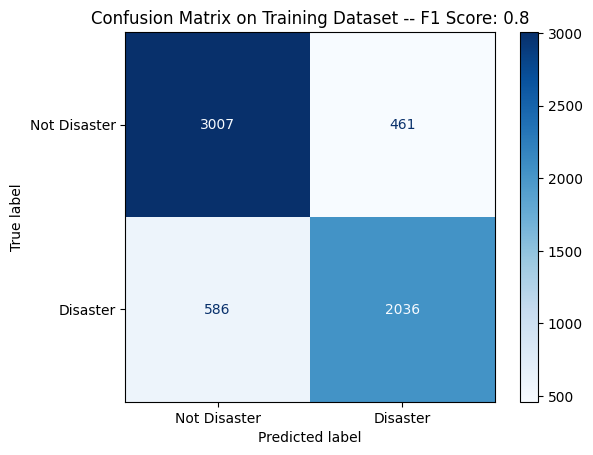

In [19]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

# **7. Generate Submission File**

In [ ]:
# Generate predictions
test_pred = np.argmax(classifier.predict(X_test), axis = 1)

# Get the test_ids from the test data
test_ids = df_test["id"]

# Create a DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'target': test_pred
})

# Optional: Check the DataFrame to ensure it looks correct
print(submission_df.head())

# Save the DataFrame to a CSV file
submission_df.to_csv(directory + 'submission.csv', index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
